In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import glob 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import durbin_watson
from scipy import stats # For the Shapiro-Wilk test
from statsmodels.stats.diagnostic import linear_reset
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline


In [5]:
base_path='/kaggle/input/playground-series-s5e9'

## 1. Tip 
 we use this practice when working with multiple files and accessing them with only names this makes code much more clean to work with and debug 

In [6]:
training_file_path=os.path.join(base_path,'train.csv')

In [7]:
train_df=pd.read_csv(training_file_path)

## 2. Tip
first step to any data analysis is removing the name tags and  id's
this information is not useful to model  

In [8]:
## Dropping Id Column
train_df.drop(columns='id',inplace=True)

In [9]:
## Lets Seperate our Target and Features 
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,-1]

## 🎒 Now That Our Data is Prepared, Let's Look in Our Tool Bag of Models
We're going to explore two new models:

1. Multiple Linear Regression

2. Polynomial Regression

These models are different from tree-based models. We call them parametric models. A simple way to think about it is that their results can be drawn as a smooth line or curve on a graph, almost like drawing without lifting your pencil!

These models come with some pros and cons:

👍 Pros
Easy to understand and explain: They work by fitting a mathematical equation to the data. You've probably seen the basic equation for a line in math class: y = kx + c. Our models are just a more powerful version of this!

👎 Cons
They have assumptions: This is the most important part! These models only work well if your data follows certain rules (we call these "assumptions"). If we ignore these rules, our model's results might just be a fluke and could give us the wrong insights.

# 🧐 So, What Are These Assumptions?


These are the "rules" our model needs the data to follow. If the data follows these rules, we can trust our model's results.

1. Linearity: The data should look like it forms a rough line (or a flat plane, for MLR). It shouldn't look like a wild roller-coaster or a "U" shape.

2. Independence: The mistakes  our model makes should be random. A mistake for one data point shouldn't help you predict the mistake for the next data point.

3. Homoscedasticity (A fancy word!): This means the "spread" of the mistakes should be pretty even all along the line. You don't want your model to be really accurate for small values but get wildly wrong for large values. The "mess" of mistakes should be consistent.

4. Normality: If you made a collection of all the model's mistakes and made a bar chart (histogram) of them, they should look like a "bell curve." This just means most mistakes are small, and very few mistakes are huge.

5. No Multicollinearity (For MLR only): This one is for Multiple Linear Regression. It means your input variables (like "study hours" and "sleep hours") shouldn't be too similar. If two variables are basically telling the model the same thing, it gets confused and can't figure out which one is actually important.

We will take a look at each assumption with the help of diagrams.

🔑 Clearing Up Some Key Terms
Before we dive into the diagrams, let's get some "jargon" (tricky words) cleared up.

Predicted (or Fitted) Values: This is simply the guess (or prediction) that our model makes.

Residual: This is the mistake or leftover amount. It's the difference between the actual value (the real answer) and the predicted value (what our model guessed).

Residual = Actual Value - Predicted Value

Simple Example:

You actually got a 90 on a test. (This is the Actual Value)

Our model looked at your study hours and predicted you would get an 85. (This is the Predicted Value)

The Residual (the mistake) is +5. (90 - 85 = 5)

(Note: We call this "residual" because it's the "leftover" part that the model couldn't explain!)

# 🤔 Residual vs. Error (A Tricky but Important Idea)


This confuses even professional data scientists, so let's use an analogy.

Imagine you are playing darts, trying to hit the bullseye (the "true" answer).

### The ERROR (or "Disturbance")

This is the true, hidden, random factor that you can't control or even see.

Think of it as a tiny, invisible breeze that nudges your dart even if your throw was perfect.

Error is theoretical. We can never know the exact "error" because we can't know the perfect model of the universe (or the exact strength of that invisible breeze).

### The RESIDUAL

This is the measured mistake after you've thrown your dart (built your model).

You throw, and the dart lands 2 inches to the right of the bullseye. That "2 inches" is the residual. You can see it, measure it, and write it down.



# So, what's the difference? 🤔



The Residual (the 2 inches you can measure) is what your specific model got wrong.

The Error (the invisible breeze) is the true randomness in the world that no model can ever capture.

Why does this matter? All those "assumptions" (like "Normality" or "Homoscedasticity") are technically about the invisible Errors.

But since we can't see the errors, what do we do? We look at our Residuals! We use our residuals as a "best guess" or "estimate" to check if the assumptions about the "errors" are being broken.

--- Creating Initial Scatter Plots (Linearity Check) ---
Plotting RhythmScore vs. Y


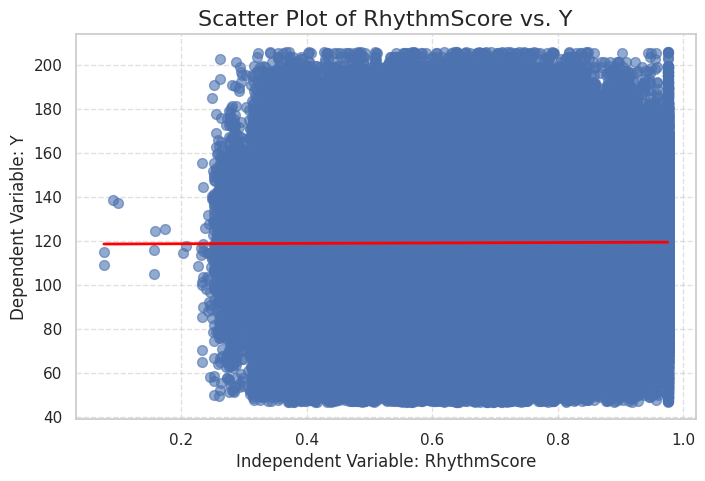

Plotting AudioLoudness vs. Y


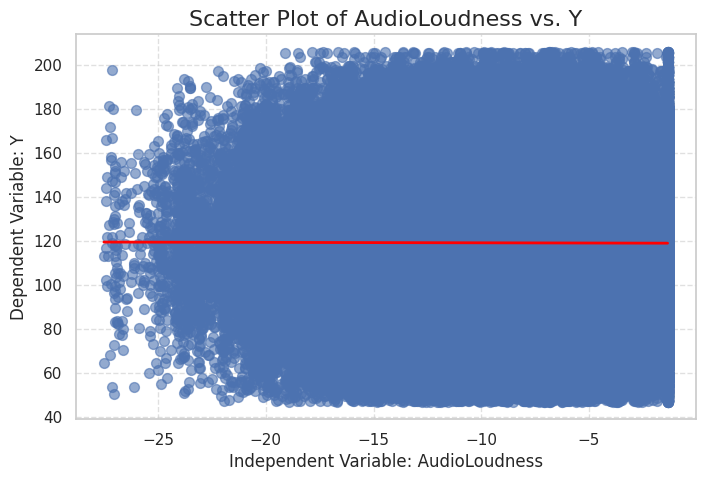

Plotting VocalContent vs. Y


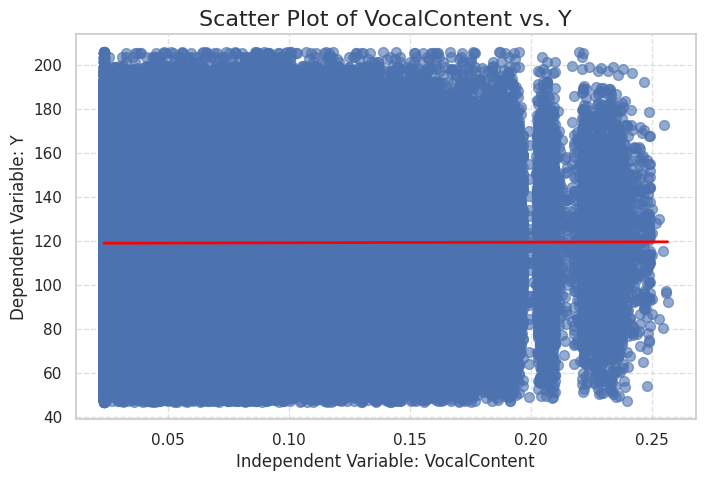

Plotting AcousticQuality vs. Y


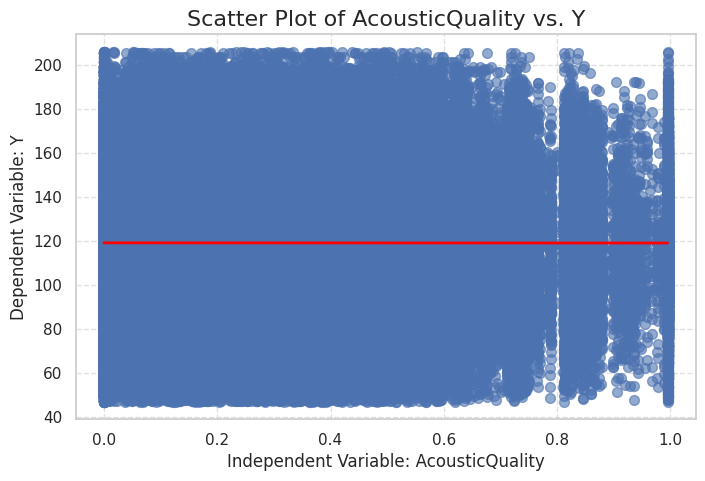

Plotting InstrumentalScore vs. Y


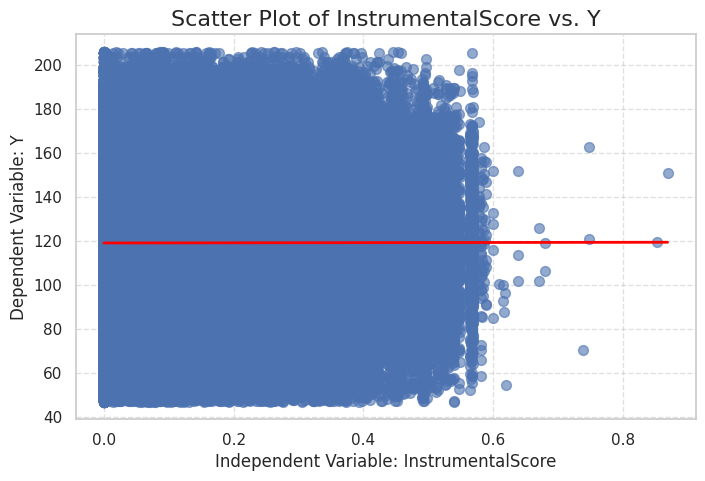

Plotting LivePerformanceLikelihood vs. Y


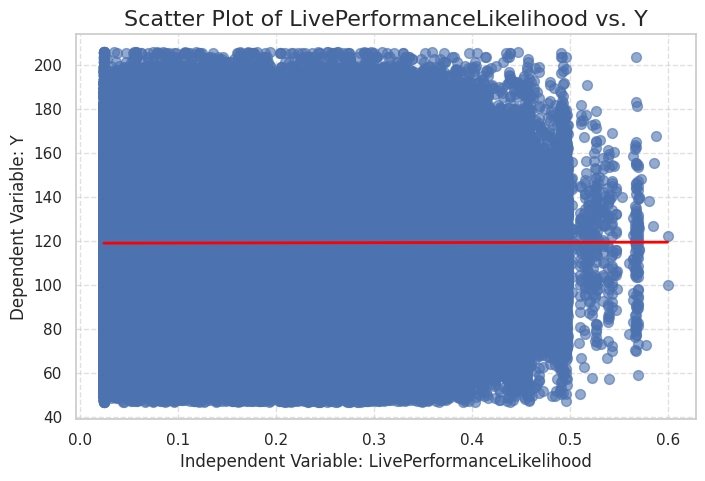

Plotting MoodScore vs. Y


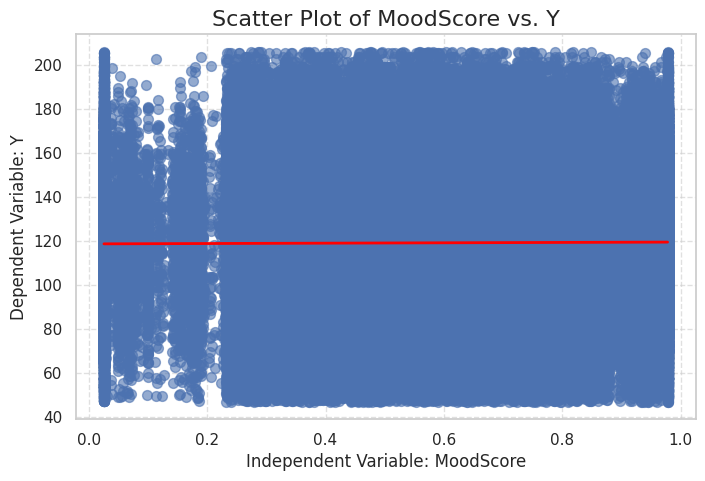

Plotting TrackDurationMs vs. Y


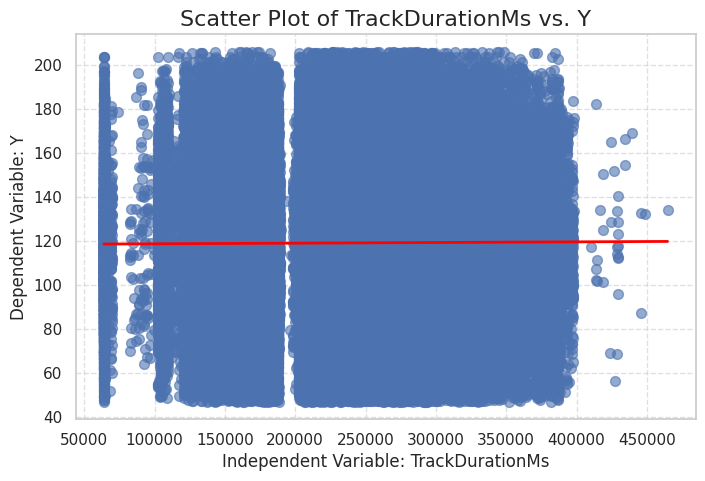

Plotting Energy vs. Y


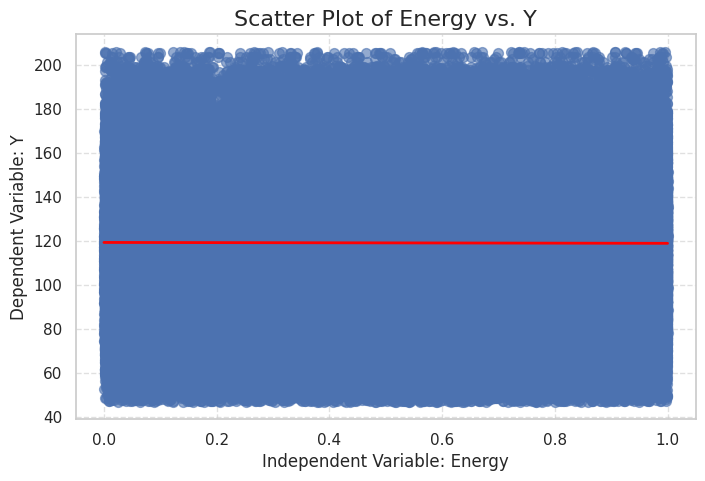

--- Initial Scatter Plots Done ---


In [10]:


print("--- Creating Initial Scatter Plots (Linearity Check) ---")

# Check if X_train is a DataFrame (for .columns)
if not isinstance(X_train, pd.DataFrame):
    print("X_train is not a DataFrame. Please ensure X_train is a pandas DataFrame.")
else:
    # If you have multiple independent variables, iterate and plot each one
    for col in X_train.columns:
        print(f"Plotting {col} vs. Y")
        
        # Use a regression line plot (regplot) to see the linear trend
        plt.figure(figsize=(8, 5)) # Create a new figure for each plot
        sns.regplot(x=col, y=y_train, data=train_df, ci=None,
                    scatter_kws={'alpha': 0.6, 's': 50}, # Make points slightly transparent
                    line_kws={'color': 'red', 'lw': 2}) # Make line stand out
        
        plt.title(f'Scatter Plot of {col} vs. Y', fontsize=16)
        plt.xlabel(f'Independent Variable: {col}', fontsize=12)
        plt.ylabel('Dependent Variable: Y', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6) # Add a light grid
        plt.show()

print("--- Initial Scatter Plots Done ---")

## Looks like a lot to handle, right? 🤔


So, let's start small. We'll first create our own simple "dummy" dataset where we know exactly what the rules are.

We can practice using our tools on this simple data, and once we see how they work, we'll be ready to use them on bigger, more complex data

--- Step 1: Create dummy data for Multiple Linear Regression ---
Dummy data created. Here's a sample:
         X1        X2        X3          y
0  3.745401  1.935559  6.420316   7.923914
1  9.507143  6.026392  0.841400  19.505785
2  7.319939  4.288682  1.616287  20.694617
3  5.986585  4.010434  8.985542  12.167316
4  1.560186  2.595226  6.064291   1.865974


Plotting initial relationships...


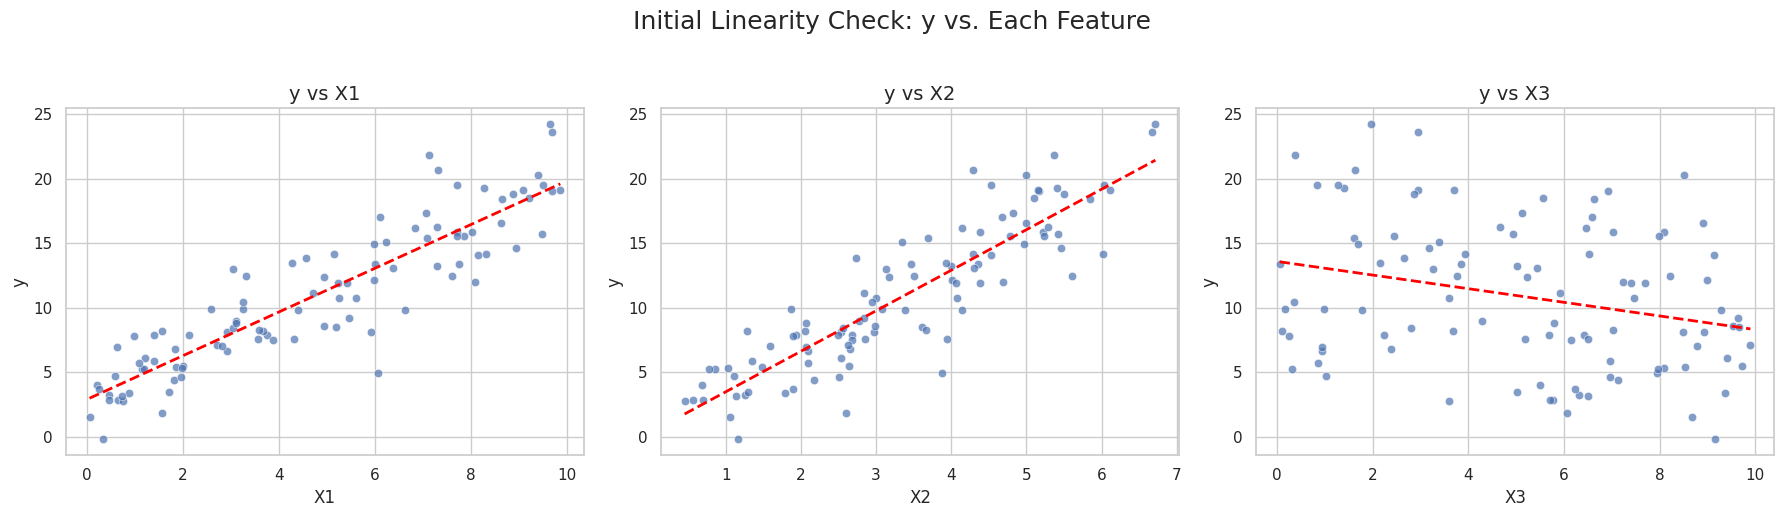

Initial plots complete.


In [11]:
# Set a nice visual style for the plots
sns.set_theme(style="whitegrid")

print("--- Step 1: Create dummy data for Multiple Linear Regression ---")
np.random.seed(42) # So we get the same "random" data every time
n_samples = 100 # Number of data points (students)

# --- Create Features (X variables) ---

# Feature 1: An independent variable (e.g., 'Study Hours')
X1 = np.random.rand(n_samples) * 10

# Feature 2: Correlated with X1 (e.g., 'Hours of Tutors')
# We make it *intentionally* correlated to test for multicollinearity later!
X2 = X1 * 0.5 + np.random.rand(n_samples) * 2

# Feature 3: Another independent variable (e.g., 'Sleep Hours')
X3 = np.random.rand(n_samples) * 10

# --- Create Noise (The "unavoidable error") ---
# This is the random "noise" that our model won't be able to predict
noise = np.random.randn(n_samples) * 2

# --- Create Target (y variable) ---
# We create y using a clear linear relationship + noise
# y = 5 + 1.2*X1 + 0.8*X2 - 0.5*X3 + noise
# (These numbers are the "true" coefficients)
y = 5 + (1.2 * X1) + (0.8 * X2) - (0.5 * X3) + noise

# --- Put it all in a DataFrame ---
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
print("Dummy data created. Here's a sample:")
print(df.head())
print("\n")


# --- Step 2: Plot the data (Initial Linearity Check) ---
print("Plotting initial relationships...")

# Create 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Initial Linearity Check: y vs. Each Feature', fontsize=18, y=1.03)

# Loop through each feature and its corresponding plot
for ax, col in zip(axes, ['X1', 'X2', 'X3']):
    # Create the scatter plot
    sns.scatterplot(x=df[col], y=df['y'], ax=ax, alpha=0.7)
    
    # Fit a simple OLS line (degree 1 polynomial) just for a visual check
    coefs = np.polyfit(df[col], df['y'], 1)
    
    # Create x-values for the line
    xs = np.linspace(df[col].min(), df[col].max(), 100)
    
    # Plot the OLS line
    ax.plot(xs, np.polyval(coefs, xs), linestyle='--', color='red', lw=2)
    
    ax.set_title(f'y vs {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('y', fontsize=12)

plt.tight_layout()
plt.show()

print("Initial plots complete.")

## What if the Plot is Hard to Read?😖


The "Residual vs. Fitted" plot is our best friend for checking linearity. But sometimes, just "eyeballing" a plot is tricky. What if you have a million data points and it just looks like a big messy blob?



#### When our eyes aren't enough, we can use a special tool.

## 🤖 A "Robot" Helper: The RESET Test
Think of the RESET test as a robot detective that looks for "hidden curves" or "U-shapes" that we might miss.

You don't need to worry about the complicated math inside the robot. You just need to know how to read the final score it gives you. That score is called a p-value.

How to Read the p-value (The Simple Rule):

We are looking for a high p-value. Our "magic number" is 0.05.

p-value > 0.05 (like 0.10, 0.50, or 0.99)

✅ PASS!

This means the robot found no evidence of a hidden curve. Your model passes the linearity test!

p-value < 0.05 (like 0.03, 0.01, or 0.001)

❌ FAIL!

This means the robot found a problem. There is strong evidence of a hidden curve. Your model is not linear, and you'll need to do something to fix it.

In [12]:
# --- Step 1: Create the same dummy data as before ---
# We need this data to run our test on!
np.random.seed(42)
n_samples = 100
X1 = np.random.rand(n_samples) * 10
X2 = X1 * 0.5 + np.random.rand(n_samples) * 2
X3 = np.random.rand(n_samples) * 10
noise = np.random.randn(n_samples) * 2
y = 5 + (1.2 * X1) + (0.8 * X2) - (0.5 * X3) + noise
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})

print("--- Data created. Starting RESET tests. ---")
print("Remember: We want a p-value > 0.05 for the model to pass.")


# --- Test 1: Full Model (Using X1, X2, and X3) ---

# We add a 'constant' (the 'c' in y=mx+c) to our X variables.
# Statsmodels needs this to work correctly.
X_full = sm.add_constant(df[['X1', 'X2', 'X3']])
model_full = sm.OLS(df['y'], X_full).fit()

# Run the RESET test
# (The 'power=2' part just tells the test how to look for curves)
reset_test_full = linear_reset(model_full, power=2, use_f=True)
p_value_full = reset_test_full.pvalue

print("\n--- Test 1: Full Model (X1, X2, X3) ---")
print(f"p-value = {p_value_full:.4f}") # Format to 4 decimals

if p_value_full > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("Result: ❌ FAIL! (p-value is < 0.05)")


# --- Test 2: Simple Model (Using only X3) ---
X_simple = sm.add_constant(df[['X3']])
model_simple = sm.OLS(df['y'], X_simple).fit()

# Run the RESET test
reset_test_simple = linear_reset(model_simple, power=2, use_f=True)
p_value_simple = reset_test_simple.pvalue

print("\n--- Test 2: Simple Model (Just X3) ---")
print(f"p-value = {p_value_simple:.4f}") # Format to 4 decimals

if p_value_simple > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("Result: ❌ FAIL! (p-value is < 0.05)")

print("\n--- Tests Complete. ---")

--- Data created. Starting RESET tests. ---
Remember: We want a p-value > 0.05 for the model to pass.

--- Test 1: Full Model (X1, X2, X3) ---
p-value = 0.4181
Result: ✅ PASS! (p-value is > 0.05)

--- Test 2: Simple Model (Just X3) ---
p-value = 0.2868
Result: ✅ PASS! (p-value is > 0.05)

--- Tests Complete. ---


## So looking at P-values which model has stronger linearity ? 🤔



⚠️ A Common Trap: Comparing p-values

You might notice that the p-value for the second test (0.2868) is "lower" than the p-value for the first test (0.4181).

It's very tempting to think this means the linearity is "weaker" in the second model. This is a common trap!

Here's the most important rule: A p-value is a "pass/fail" test, not a "score" of strength.1

In [13]:
### Enough of dummy lets try the same on our data as well 

In [14]:
X_train

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333
...,...,...,...,...,...,...,...,...,...
524159,0.796831,-13.405645,0.023500,0.504738,0.000001,0.191414,0.668079,135528.3189,0.004400
524160,0.975000,-12.132914,0.077379,0.069462,0.262320,0.124818,0.288946,240709.3918,0.447067
524161,0.542958,-1.357000,0.071390,0.168978,0.000001,0.313912,0.586868,344858.2321,0.718800
524162,0.637192,-7.411331,0.113086,0.000005,0.061946,0.287963,0.368891,322710.3187,0.944267


In [15]:
X_actual = sm.add_constant(X_train[['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality',
       'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore',
       'TrackDurationMs', 'Energy']])
model = sm.OLS(y_train, X_actual).fit()

# Ramsey RESET test
reset_test = linear_reset(model, power=4, use_f=True)
print(reset_test)



<F test: F=2.741518999718322, p=0.0644732635212402, df_denom=5.24e+05, df_num=2>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


In [16]:
## so our actual data shows it is highly unlikely to have linearity in demo 
## we will verify this with actual fits as well on leaderboard 
## Remember no model fits all the data 

## ✅ Assumption 2: Independence of Errors
The Rule: The errors (residuals) are random and not correlated with each other. The error for one data point should not tell you anything about the error for the next data point.

In Simple Terms: Your model's mistakes should look completely random. If your mistakes show a clear pattern (like a wave or a snake), it means there was a pattern in the data that your model missed.

We will use two tools to check for this:

A Graphical Plot: We plot the residuals (mistakes) in the order they happened.

A Statistical Test: We use a test called the Durbin-Watson test.

## Tool 1: The Residuals vs. Order Plot

We plot our residuals one after another, like a heartbeat monitor.

#### ✅ What We Want (Good): 
A messy, random "static" or "white noise" plot. It should have no obvious pattern.

#### ❌ Red Flag (Bad): 
A "snake-like" or "wave-like" pattern. This shows that a positive mistake is often followed by another positive mistake (or a negative one). This is a common failure.


## Tool 2: The Durbin-Watson (DW) Test

This is a "robot detective" that gives us a single score to tell us if there's a pattern.

The Magic Number: We want our score to be as close to 2.0 as possible.

#### ✅ PASS: 
A score around 2.0 (e.g., between 1.5 and 2.5) is usually good. It means the residuals are independent.

#### ❌ FAIL: 
A score far from 2.0 (like 0.8 or 3.2) is a red flag. It means there's a pattern, and our assumption is broken.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


--- Creating data with INDEPENDENT errors (GOOD case) ---
Plotting 'GOOD' residuals... (Should look random)


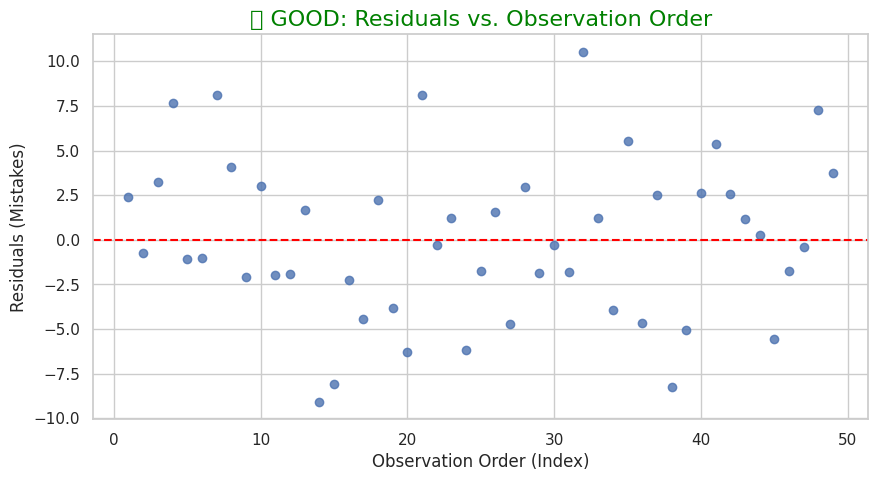


--- Durbin-Watson Test Result (GOOD Case) ---
Durbin-Watson Statistic: 1.91
Result: ✅ PASS! The statistic is close to 2.0.

-------------------------------------------------

--- Creating data with CORRELATED errors (BAD case) ---
Plotting 'bad' residuals... (Should show a pattern)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


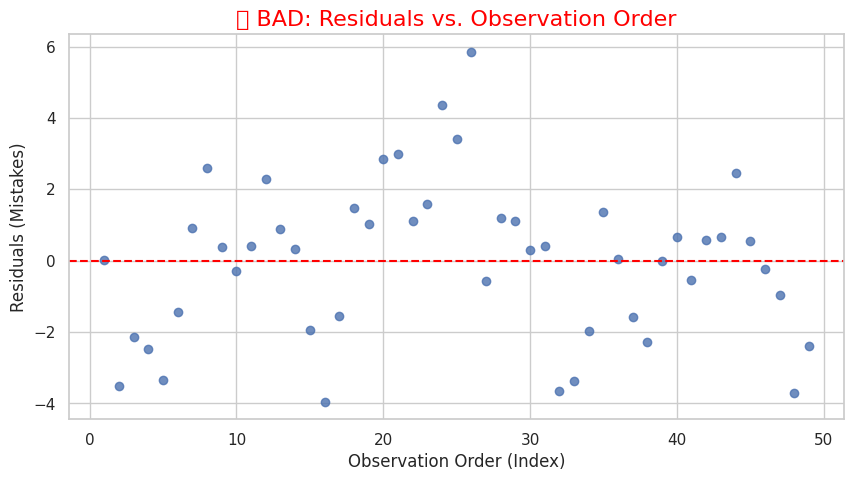


--- Durbin-Watson Test Result (BAD Case) ---
Durbin-Watson Statistic: 0.82

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      ❌❌❌ F A I L ❌❌❌
Result: This is a RED FLAG. The statistic is far from 2.0.
This means our assumption of independence is BROKEN.

Notice how this 'bad' plot has a D-W score (around 0.82)
that is very far from the 'good' plot's score (around 1.91).
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [17]:
# Set a nice style
sns.set_theme(style="whitegrid")

print("--- Creating data with INDEPENDENT errors (GOOD case) ---")

# --- Step 1: Create sample data ---
# We are making "good" data where the errors are truly random
# Adding np.random.seed(42) makes sure you get the same "random"
# data every time you run the code, which is good for teaching.
np.random.seed(42)
x_good = np.arange(1, 50)
# This is the line y = 2x + (random noise)
y_good = 2 * x_good + np.random.normal(0, 5, size=len(x_good))

# --- Step 2: Fit a model and get residuals ---
model_good = LinearRegression()
model_good.fit(x_good.reshape(-1, 1), y_good)
# Residuals = Actual (y_good) - Predicted
residuals_good = y_good - model_good.predict(x_good.reshape(-1, 1))

# --- Step 3: Plot the residuals ---
print("Plotting 'GOOD' residuals... (Should look random)")
plt.figure(figsize=(10, 5))
# Use scatter for individual points
plt.scatter(x_good, residuals_good, alpha=0.8)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("✅ GOOD: Residuals vs. Observation Order", fontsize=16, color='green')
plt.xlabel("Observation Order (Index)")
plt.ylabel("Residuals (Mistakes)")
plt.show()

# --- Step 4: Run the Durbin-Watson test ---
dw_good = durbin_watson(residuals_good)
print("\n--- Durbin-Watson Test Result (GOOD Case) ---")
# Format the output to be clearer (f-string)
print(f"Durbin-Watson Statistic: {dw_good:.2f}")

# Add an interpretation to make it easy for students
if 1.5 < dw_good < 2.5:
    print("Result: ✅ PASS! The statistic is close to 2.0.")
else:
    print("Result: ❌ FAIL! The statistic is far from 2.0.")

print("\n-------------------------------------------------\n")

# --- Now, let's create a BAD example ---
print("--- Creating data with CORRELATED errors (BAD case) ---")

# We will make "bad" data where each error depends on the last one
x_bad = np.arange(1, 50)
y_bad = np.zeros_like(x_bad, dtype=float)
noise_bad = np.zeros_like(x_bad, dtype=float)

# Create correlated noise (an "autocorrelated" series)
for i in range(1, len(x_bad)):
    # This error is 80% of the last error + a little new noise
    noise_bad[i] = 0.8 * noise_bad[i-1] + np.random.normal(0, 2)
    
y_bad = 2 * x_bad + noise_bad # Add the "bad" noise to the line

# Fit model and get residuals
model_bad = LinearRegression()
model_bad.fit(x_bad.reshape(-1, 1), y_bad)
residuals_bad = y_bad - model_bad.predict(x_bad.reshape(-1, 1))

# Plot the "bad" residuals
print("Plotting 'bad' residuals... (Should show a pattern)")
plt.figure(figsize=(10, 5))
plt.scatter(x_bad, residuals_bad, alpha=0.8) # Use scatter
plt.axhline(y=0, color='red', linestyle='--')
plt.title("❌ BAD: Residuals vs. Observation Order", fontsize=16, color='red')
plt.xlabel("Observation Order (Index)")
plt.ylabel("Residuals (Mistakes)")
plt.show()

# Run the Durbin-Watson test on the "bad" data
dw_bad = durbin_watson(residuals_bad)
print("\n--- Durbin-Watson Test Result (BAD Case) ---")
print(f"Durbin-Watson Statistic: {dw_bad:.2f}")

if 1.5 < dw_bad < 2.5:
    print("Result: ✅ PASS! The statistic is close to 2.0.")
else:
    # Make the "FAIL" message much more obvious and readable
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("      ❌❌❌ F A I L ❌❌❌")
    print("Result: This is a RED FLAG. The statistic is far from 2.0.")
    print("This means our assumption of independence is BROKEN.")
    print("\nNotice how this 'bad' plot has a D-W score (around 0.82)")
    print("that is very far from the 'good' plot's score (around 1.91).")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

## ✅ Assumption 3: Homoscedasticity (A Fancy Word for "Same Spread")

#### The Rule: 
The "messiness" (or variance) of the errors is constant across all levels of the independent variables.

#### In Simple Terms: 
The "spread" of your model's mistakes should be even. You don't want a "cone" or "fan" shape, where the model gets wildly less accurate as the predicted values get bigger.



### Tool 1: The Residual vs. Fitted Plot

We use the exact same plot we used for the Linearity check!

#### ✅ What We Want (Good): 
A boring, random cloud of dots. The vertical spread of the dots should be the same on the left side (for small predictions) and the right side (for big predictions).

#### ❌ Red Flag (Bad): 
A "cone" or "fan" shape. If the dots get more spread out (like a megaphone), it means our model is great at small predictions but terrible at
large ones (or vice-versa).



### Tool 2: The Breusch-Pagan (BP) Test

Just like before, when our eyes might fail us, we have a "robot detective" to help.

How to Read the p-value: We are looking for a high p-value. Our "magic number" is 0.05.

#### p-value > 0.05 (like 0.10, 0.50, or 0.99)

✅ PASS!

This means the robot found no evidence of a "cone" shape. The spread is even!

#### p-value < 0.05 (like 0.03, 0.01, or 0.001)

❌ FAIL!

This means the robot found a problem. There is strong evidence of a "cone" shape (this is called "heteroscedasticity").

--- Running Homoscedasticity Demo ---


/tmp/ipykernel_48/1724799542.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/1724799542.py:49: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


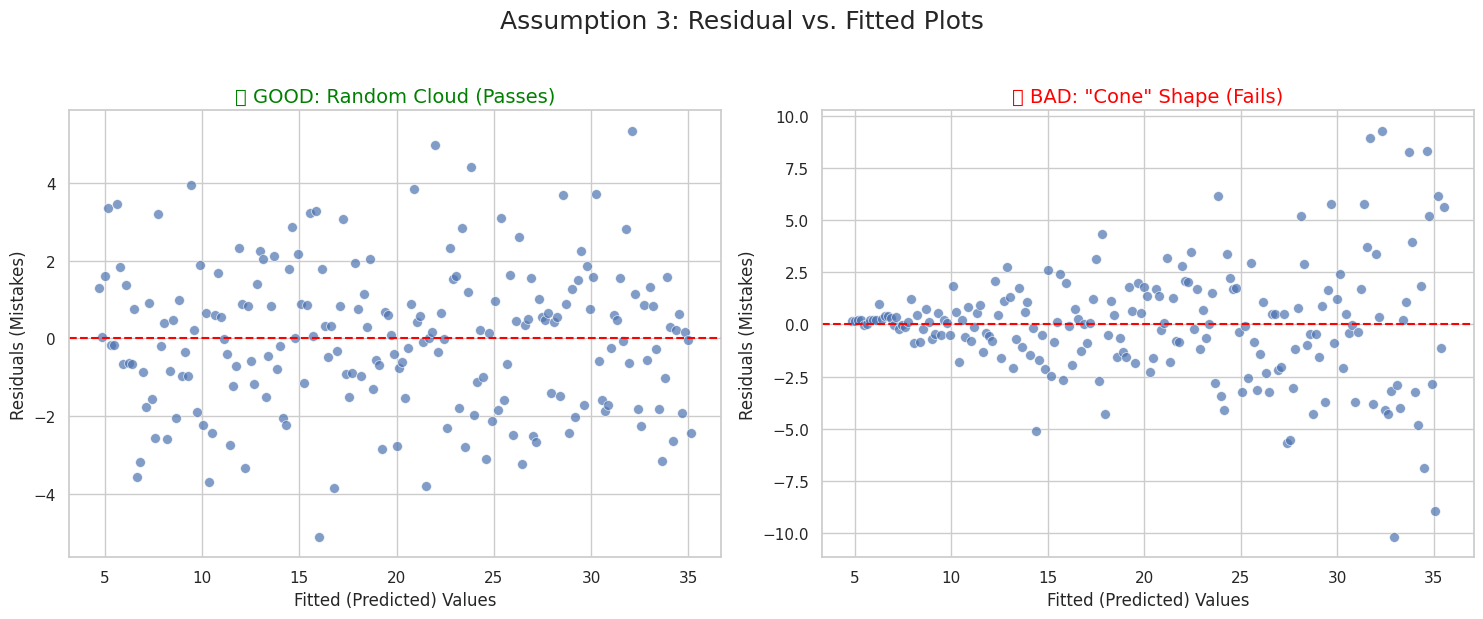


--- Breusch-Pagan Test Result (GOOD Case) ---
p-value: 0.9588
Result: ✅ PASS! (p-value is > 0.05)

--- Breusch-Pagan Test Result (BAD Case) ---
p-value: 0.0000

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      ❌❌❌ F A I L ❌❌❌
Result: This is a RED FLAG. The p-value is < 0.05.
This confirms what we saw in the 'cone' plot.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import LinearRegression

# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(42) # for reproducible results
N_SAMPLES = 200 # Number of data points

print("--- Running Homoscedasticity Demo ---")

# --- 1. GOOD Case (Constant "spread" of noise) ---
X_good = np.linspace(0, 10, N_SAMPLES)
# Y = 3*X + 5 + (random noise with a CONSTANT spread of 2)
y_good = 3 * X_good + 5 + np.random.normal(0, 2, N_SAMPLES) 
model_good = LinearRegression().fit(X_good.reshape(-1, 1), y_good)
preds_good = model_good.predict(X_good.reshape(-1, 1))
resids_good = y_good - preds_good

# --- 2. BAD Case ("Cone" shape, noise increases with X) ---
X_bad = np.linspace(0, 10, N_SAMPLES)
# Y = 3*X + 5 + (random noise where spread INCREASES with X)
error_bad = np.random.normal(0, 0.5 * X_bad, N_SAMPLES) # The 'bad' part!
y_bad = 3 * X_bad + 5 + error_bad
model_bad = LinearRegression().fit(X_bad.reshape(-1, 1), y_bad)
preds_bad = model_bad.predict(X_bad.reshape(-1, 1))
resids_bad = y_bad - preds_bad

# --- 3. Plotting Both Cases ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Assumption 3: Residual vs. Fitted Plots', y=1.03, fontsize=18)

# GOOD Plot
sns.scatterplot(x=preds_good, y=resids_good, ax=ax1, s=50, alpha=0.7)
ax1.axhline(0, ls='--', color='red')
ax1.set_title('✅ GOOD: Random Cloud (Passes)', fontsize=14, color='green')
ax1.set_xlabel('Fitted (Predicted) Values', fontsize=12)
ax1.set_ylabel('Residuals (Mistakes)', fontsize=12)

# BAD Plot
sns.scatterplot(x=preds_bad, y=resids_bad, ax=ax2, s=50, alpha=0.7)
ax2.axhline(0, ls='--', color='red')
ax2.set_title('❌ BAD: "Cone" Shape (Fails)', fontsize=14, color='red')
ax2.set_xlabel('Fitted (Predicted) Values', fontsize=12)
ax2.set_ylabel('Residuals (Mistakes)', fontsize=12)
plt.tight_layout()
plt.show()

# --- 4. Run the Breusch-Pagan Test ---
# Statsmodels needs the 'X' to have a constant
X_good_sm = sm.add_constant(X_good)
X_bad_sm = sm.add_constant(X_bad)

# Run test on GOOD residuals
bp_test_good = het_breuschpagan(resids_good, X_good_sm)
p_value_good = bp_test_good[1]

print("\n--- Breusch-Pagan Test Result (GOOD Case) ---")
print(f"p-value: {p_value_good:.4f}")
if p_value_good > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("Result: ❌ FAIL! (p-value is < 0.05)")

# Run test on BAD residuals
bp_test_bad = het_breuschpagan(resids_bad, X_bad_sm)
p_value_bad = bp_test_bad[1]

print("\n--- Breusch-Pagan Test Result (BAD Case) ---")
print(f"p-value: {p_value_bad:.4f}")
if p_value_bad > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("      ❌❌❌ F A I L ❌❌❌")
    print("Result: This is a RED FLAG. The p-value is < 0.05.")
    print("This confirms what we saw in the 'cone' plot.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

## ✅ Assumption 4: Normality of Errors

### The Rule: 
The model's mistakes (residuals) should be "normally distributed."

### In Simple Terms: 
This just means the mistakes should follow a bell curve. Most of your mistakes should be very small (close to 0), and you should have very few huge mistakes.




### Tool 1: The Q-Q (Quantile-Quantile) Plot

This is a special plot that's perfect for checking for a bell curve.

✅ What We Want (Good): All the blue dots (our mistakes) stick very closely to the red diagonal line (the "perfect" bell curve). If they are all on the line, we pass!

❌ Red Flag (Bad): The blue dots form an "S" shape or curve away from the red line, especially at the ends. This means our mistakes don't follow a bell curve, and we have too many large mistakes (or the mistakes are lopsided).



### Tool 2: The Shapiro-Wilk Test

This is another "robot detective" that's excellent at checking for the bell curve shape.

How to Read the p-value: We are looking for a high p-value. Our "magic number" is 0.05.

p-value > 0.05 (like 0.10, 0.50, or 0.99)

✅ PASS!

This means the robot found no evidence that our data is not a bell curve.

p-value < 0.05 (like 0.03, 0.01, or 0.001)

❌ FAIL!

This means the robot found a problem. Our mistakes are not normally distributed.

--- Running Normality of Errors Demo ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_48/2723444213.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/2723444213.py:31: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/py

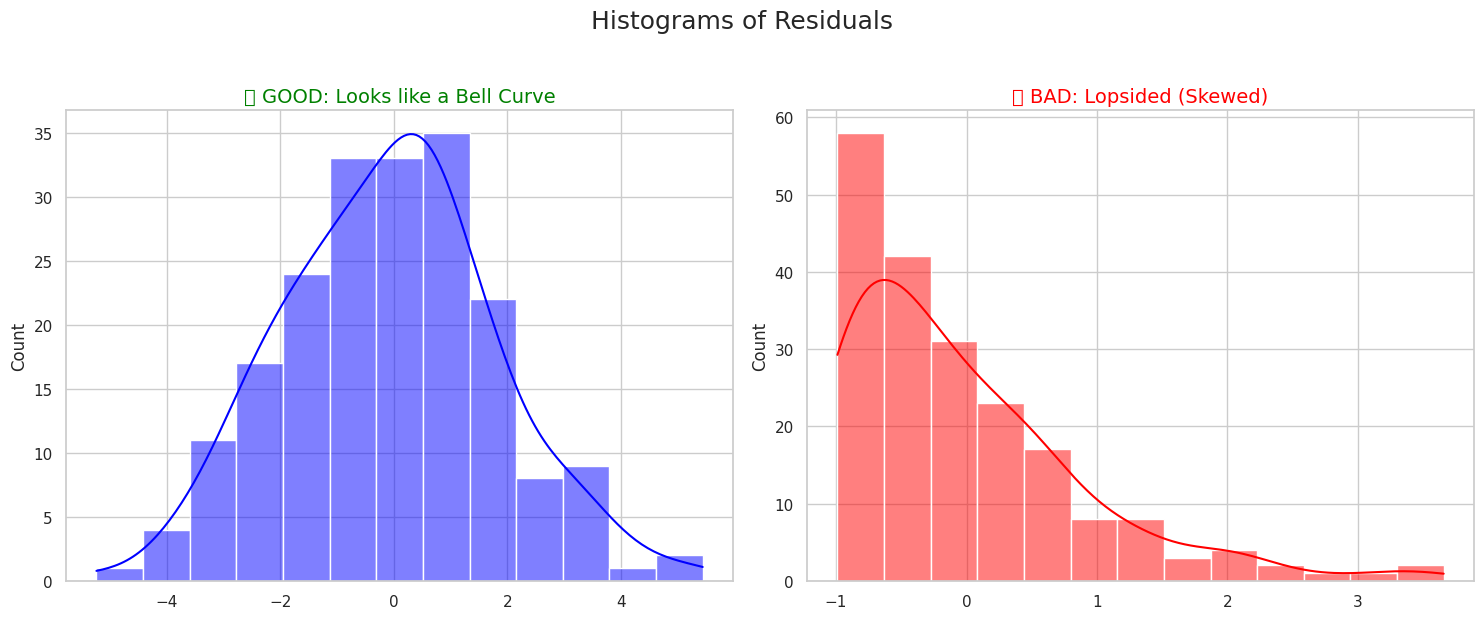

/tmp/ipykernel_48/2723444213.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_48/2723444213.py:49: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()


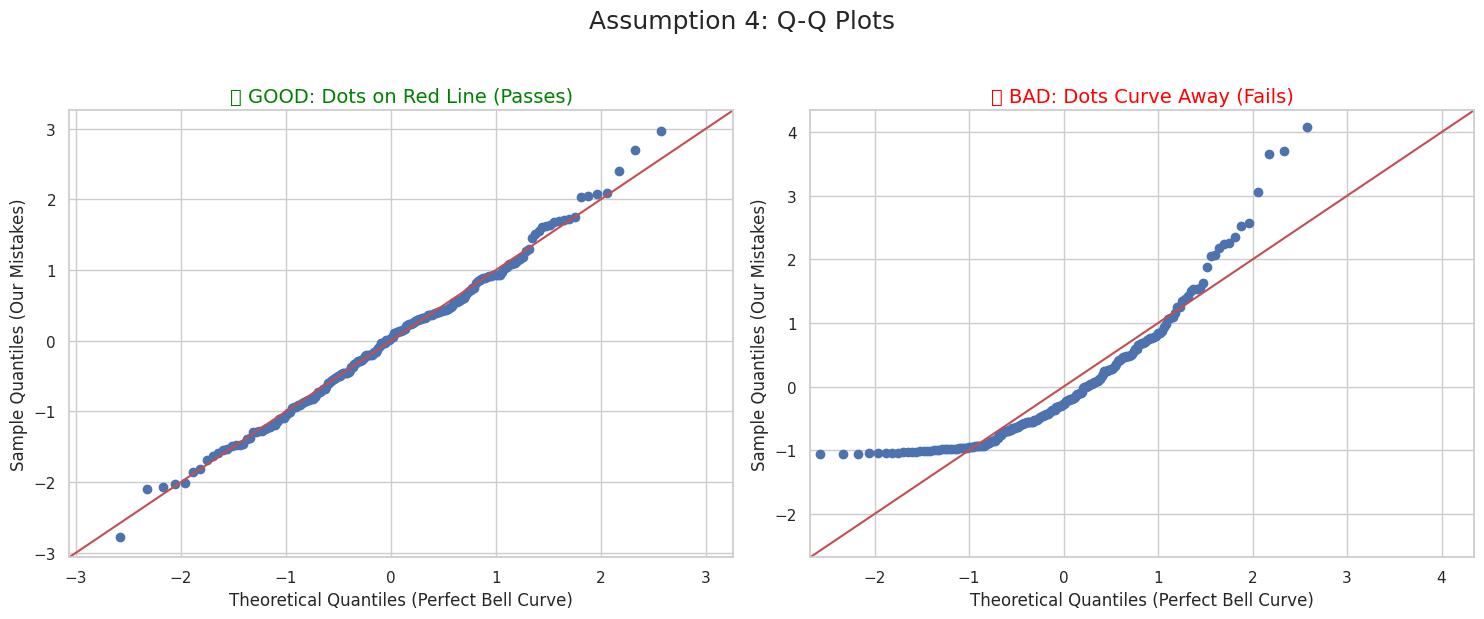


--- Shapiro-Wilk Test Result (GOOD Case) ---
p-value: 0.8290
Result: ✅ PASS! (p-value is > 0.05)

--- Shapiro-Wilk Test Result (BAD Case) ---
p-value: 0.0000

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      ❌❌❌ F A I L ❌❌❌
Result: The p-value (0.000000) is tiny!
This confirms the data is NOT a bell curve.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(42) # for reproducible results
N_SAMPLES = 200 # Number of data points

print("--- Running Normality of Errors Demo ---")

# --- 1. GOOD Residuals (Normally distributed "bell curve") ---
# We create residuals directly from the "normal" (bell curve) function
resids_good = np.random.normal(0, 2, N_SAMPLES)

# --- 2. BAD Residuals (Skewed) ---
# We use an "exponential" function, which is very lopsided, not a bell curve
resids_bad = np.random.exponential(1, N_SAMPLES) - 1

# --- 3. Plotting Both Cases (Histograms) ---
# A histogram helps to see the shape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Histograms of Residuals', y=1.03, fontsize=18)

sns.histplot(resids_good, kde=True, ax=ax1, color='blue')
ax1.set_title('✅ GOOD: Looks like a Bell Curve', fontsize=14, color='green')

sns.histplot(resids_bad, kde=True, ax=ax2, color='red')
ax2.set_title('❌ BAD: Lopsided (Skewed)', fontsize=14, color='red')
plt.tight_layout()
plt.show()

# --- 4. Plotting Both Cases (Q-Q Plots) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Assumption 4: Q-Q Plots', y=1.03, fontsize=18)

# GOOD Plot
sm.qqplot(resids_good, line='45', fit=True, ax=ax1)
ax1.set_title('✅ GOOD: Dots on Red Line (Passes)', fontsize=14, color='green')
ax1.set_xlabel("Theoretical Quantiles (Perfect Bell Curve)", fontsize=12)
ax1.set_ylabel("Sample Quantiles (Our Mistakes)", fontsize=12)

# BAD Plot
sm.qqplot(resids_bad, line='45', fit=True, ax=ax2)
ax2.set_title('❌ BAD: Dots Curve Away (Fails)', fontsize=14, color='red')
ax2.set_xlabel("Theoretical Quantiles (Perfect Bell Curve)", fontsize=12)
ax2.set_ylabel("Sample Quantiles (Our Mistakes)", fontsize=12)
plt.tight_layout()
plt.show()

# --- 5. Run the Shapiro-Wilk Test ---
shapiro_test_good = stats.shapiro(resids_good)
p_value_good = shapiro_test_good.pvalue

print("\n--- Shapiro-Wilk Test Result (GOOD Case) ---")
print(f"p-value: {p_value_good:.4f}")
if p_value_good > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("Result: ❌ FAIL! (p-value is < 0.05)")

# Run test on BAD residuals
shapiro_test_bad = stats.shapiro(resids_bad)
p_value_bad = shapiro_test_bad.pvalue

print("\n--- Shapiro-Wilk Test Result (BAD Case) ---")
print(f"p-value: {p_value_bad:.4f}")
if p_value_bad > 0.05:
    print("Result: ✅ PASS! (p-value is > 0.05)")
else:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("      ❌❌❌ F A I L ❌❌❌")
    print(f"Result: The p-value ({p_value_bad:.6f}) is tiny!")
    print("This confirms the data is NOT a bell curve.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

## ✅ Assumption 5: No Multicollinearity (For MLR Only!)

### The Rule: 
This rule is only for Multiple Linear Regression (when you have X1, X2, X3, etc.). It means your input variables should not be highly correlated with each other.

### In Simple Terms: 
Your inputs should not be "copies" of each other. Each input variable should bring new and unique information to the model.

The Classic Bad Example: Imagine you have two inputs:

height_in_inches

height_in_centimeters

These two variables tell the model the exact same thing! The model gets confused and can't figure out which one is "important."



### Tool: The Variance Inflation Factor (VIF)

This is a score we calculate for each input variable. It tells us how much that variable is "explained by" the other input variables.

This time, there's no p-value. We just look at the score.

The Magic Number: We are looking for LOW scores. A common rule of thumb is that we want the score to be under 5 (or sometimes 10).

✅ PASS (Good): VIF < 5

A score near 1.0 is perfect. It means the variable is completely independent.

A score of 2, 3, or 4 is totally fine.

❌ FAIL (Bad): VIF > 5 (or > 10)

A score of 8, 20, or 100+ is a huge red flag!

It means that variable is just a "copy" or a combination of other input variables, and it's "contaminating" our model.

How to fix it: You must remove one of the "copycat" variables.

In [20]:
sns.set_theme(style="whitegrid")
np.random.seed(42) # for reproducible results
N_SAMPLES = 100 # Number of data points

print("--- Running Multicollinearity (VIF) Demo ---")

# --- 1. GOOD Case (Independent X variables) ---
# 'Study_Hours' and 'Sleep_Hours' are not related.
X1_good = np.random.normal(5, 2, N_SAMPLES) # e.g., Study Hours
X2_good = np.random.normal(8, 1, N_SAMPLES) # e.g., Sleep Hours
X3_good = np.random.normal(3, 1, N_SAMPLES) # e.g., Other Hobbies
X_df_good = pd.DataFrame({
    'Study_Hours': X1_good, 
    'Sleep_Hours': X2_good,
    'Hobby_Hours': X3_good
})

# --- 2. BAD Case (Correlated X variables) ---
X1_bad = np.random.normal(5, 2, N_SAMPLES) # e.g., 'Study_Hours'
# 'Tutor_Hours' is just 'Study_Hours' + a tiny bit of noise
# This makes them highly correlated!
X2_bad = X1_bad + np.random.normal(0, 0.2, N_SAMPLES)
X3_bad = np.random.normal(8, 1, N_SAMPLES) # e.g., 'Sleep_Hours' (independent)
X_df_bad = pd.DataFrame({
    'Study_Hours': X1_bad, 
    'Tutor_Hours': X2_bad, # The 'bad' variable
    'Sleep_Hours': X3_bad
})

# --- 3. Helper function to calculate VIF ---
def calculate_vif(df):
    """Calculates VIF scores for each column in a DataFrame."""
    # We must add a constant for the VIF function to work
    X_const = sm.add_constant(df)
    
    # Create a DataFrame to hold the VIF scores
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X_const.columns
    
    # Calculate VIF for each variable
    vif_df["VIF"] = [
        variance_inflation_factor(X_const.values, i) 
        for i in range(X_const.shape[1])
    ]
    # The VIF for 'const' is not useful, so we drop it
    return vif_df[vif_df['Variable'] != 'const']

# --- 4. Run the VIF Check ---

# GOOD Case
print("\n--- ✅ GOOD VIF Scores (Low) ---")
vif_good = calculate_vif(X_df_good)
print(vif_good)
print("\nResult: ✅ PASS! All scores are ~1.0. This is perfect.")
print("This means all our inputs are independent.")

# BAD Case
print("\n\n--- ❌ BAD VIF Scores (High) ---")
vif_bad = calculate_vif(X_df_bad)
print(vif_bad)
print("\nResult: ❌ FAIL! Look at those VIF scores for")
print("'Study_Hours' and 'Tutor_Hours'. They are huge!")
print("This tells us they are 'copies' of each other and")
print("we must remove one of them from our model.")

--- Running Multicollinearity (VIF) Demo ---

--- ✅ GOOD VIF Scores (Low) ---
      Variable       VIF
1  Study_Hours  1.056184
2  Sleep_Hours  1.019085
3  Hobby_Hours  1.037920

Result: ✅ PASS! All scores are ~1.0. This is perfect.
This means all our inputs are independent.


--- ❌ BAD VIF Scores (High) ---
      Variable        VIF
1  Study_Hours  78.214397
2  Tutor_Hours  78.082714
3  Sleep_Hours   1.017019

Result: ❌ FAIL! Look at those VIF scores for
'Study_Hours' and 'Tutor_Hours'. They are huge!
This tells us they are 'copies' of each other and
we must remove one of them from our model.


## But wait  🧠 What If Our Data Is Curved?

So far, we've only tried to fit a straight line to our data. But what if our data looks like this?

A straight line would be a terrible fit! We need a line that can bend.

# The "Trick": Polynomial Regression

The "trick" is surprisingly simple. We invent new features by just taking our original x feature and adding powers of it.

We start with just y = c + k*x (a line)

We can add an $x^2$ term: y = c + k1*x + k2*(x^2) (a curve, or "parabola")

We can add an $x^3$ term: y = c + k1*x + k2*(x^2) + k3*(x^3) (a "squiggle")

The "degree" of the polynomial is just the highest power we use.

Degree 1: Linear Regression (no curve)

Degree 2: Quadratic (one bend)

Degree 20: A super "bendy" and "wiggly" line

After we create these new features (x^2, x^3, etc.), we just feed them into the same Multiple Linear Regression model we already know!

Do the 5 Assumptions Still Apply?

Yes! A polynomial regression is just a "disguised" Multiple Linear Regression. So, all 5 assumptions still apply.

1. Linearity: This is now "linear-in-the-parameters," which is a fancy way of saying "yes." We passed this by default.

2. Independence: Still needs to be checked (Durbin-Watson $\approx$ 2).

3. Homoscedasticity: Still needs to be checked (Breusch-Pagan, p > 0.05).

4. Normality: Still needs to be checked (Shapiro-Wilk, p > 0.05).

5. Multicollinearity: This is now a huge problem! Think about it: x and x^2 are very highly correlated. This is called "structural" multicollinearity.


Because of this, we almost never use a ** "plain" ** polynomial model. We almost always use it with ** Ridge Regression **, which is excellent at handling multicollinearity!




## The Big New Problem: Overfitting

This is the most important new idea.

Underfitting (e.g., Degree 1): The model is too simple. It doesn't even capture the basic shape of the data. (High bias)

A Good Fit (e.g., Degree 2): The model is just right. It captures the main curve of the data without getting distracted by the "noise."

Overfitting (e.g., Degree 20): The model is too complex. It's so "wiggly" that it tries to hit every single data point, even the random noise. It "memorizes" the training data but will be terrible at making predictions on new data. (High variance)

Our next challenge is: How do we use a powerful, "wiggly" model (like Degree 20) without it "memorizing" the noise?

The answer is Regularization ** (Ridge & Lasso) **.

--- Running Polynomial Regression Demo ---


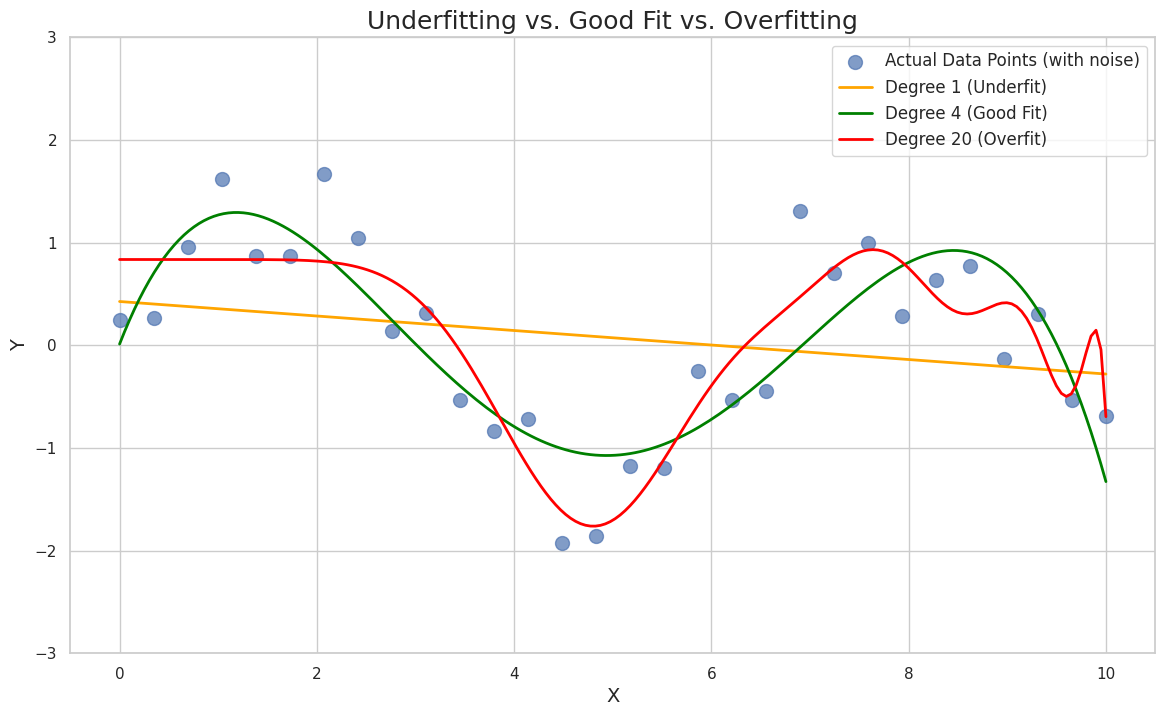


Notice how the RED line (Degree 20) is 'wiggly' and 'crazy'.
It's trying to perfectly hit every single data point.
This is OVERFITTING. It's 'memorizing' the noise.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(42) # for reproducible results
N_SAMPLES = 30 # Use fewer samples to make overfitting more obvious

print("--- Running Polynomial Regression Demo ---")

# --- 1. Create our "true" curved data ---
# We'll use a sine wave + some noise
X_true = np.linspace(0, 10, N_SAMPLES)
y_true = np.sin(X_true) + np.random.normal(0, 0.5, N_SAMPLES)

# We need to reshape X for sklearn
X_true_reshaped = X_true.reshape(-1, 1)

# --- 2. Create models of different "degrees" ---
# We use a 'Pipeline' to automatically:
#  1. Create polynomial features (e.g., x, x^2, x^3)
#  2. Fit a LinearRegression model to those features

# Degree 1: "Underfitting"
model_deg1 = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('linear', LinearRegression())
])
model_deg1.fit(X_true_reshaped, y_true)

# Degree 4: "Good Fit"
model_deg4 = Pipeline([
    ('poly', PolynomialFeatures(degree=4)),
    ('linear', LinearRegression())
])
model_deg4.fit(X_true_reshaped, y_true)

# Degree 20: "Overfitting"
model_deg20 = Pipeline([
    ('poly', PolynomialFeatures(degree=20)),
    ('linear', LinearRegression())
])
model_deg20.fit(X_true_reshaped, y_true)

# --- 3. Plot the results ---
# Create a smooth line for plotting our models' predictions
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
y_plot_deg1 = model_deg1.predict(X_plot)
y_plot_deg4 = model_deg4.predict(X_plot)
y_plot_deg20 = model_deg20.predict(X_plot)

plt.figure(figsize=(14, 8))
# Plot the original data points
plt.scatter(X_true, y_true, s=100, alpha=0.7, label="Actual Data Points (with noise)")

# Plot the model predictions
plt.plot(X_plot, y_plot_deg1, color='orange', lw=2, label="Degree 1 (Underfit)")
plt.plot(X_plot, y_plot_deg4, color='green', lw=2, label="Degree 4 (Good Fit)")
plt.plot(X_plot, y_plot_deg20, color='red', lw=2, label="Degree 20 (Overfit)")

plt.title("Underfitting vs. Good Fit vs. Overfitting", fontsize=18)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.legend(fontsize=12)
plt.ylim(-3, 3) # Keep y-axis scale the same
plt.show()

print("\nNotice how the RED line (Degree 20) is 'wiggly' and 'crazy'.")
print("It's trying to perfectly hit every single data point.")
print("This is OVERFITTING. It's 'memorizing' the noise.")

## 🚂 How to Tame the "Wiggly" Model

In the last demo, we saw the Degree 20 model went crazy. It was "overfitting" by trying to hit every point.

Why did it do that?
To get those "wiggles," the model had to use enormous coefficient values. The numbers for $x^{17}$ and $x^{18}$ might be massive, just to force the line to go up and down.

These huge coefficients make the model unstable. A tiny change in a data point can cause the entire line to change wildly.

The Solution: Regularization (A "Penalty")

Regularization is a clever trick to fix this. We add a "penalty" to the model's math. We tell the model:

"You are allowed to use complex features (like $x^{20}$), but you will be punished for using large coefficients."

This "punishment" (or "penalty") tames the model. It forces the model to find a balance between fitting the data and keeping its coefficients small and stable.

We have two main types of regularization: Ridge and Lasso.

1. Ridge Regression (L2 Penalty)

What it does: It "shrinks" all coefficients at the same time.

Analogy: Think of it as a "Team Player" penalty. It makes all coefficients "pay a tax." No single coefficient is allowed to get too big.

The Result: It smooths out the "wiggles" from our Degree 20 model, making it look more like the "Good Fit" model.

Superpower: It is fantastic at handling multicollinearity (like we have between $x$ and $x^2$). This is its main job!

The "Tuning Knob": We control the "tax rate" with a setting called alpha.

alpha=0: No penalty (just a normal, "wiggly" model).

alpha=0.1: A small penalty.

alpha=10: A huge penalty (will make the line almost flat).

2. Lasso Regression (L1 Penalty)

What it does: It also "shrinks" coefficients, but it has a special power: it can force some coefficients to become exactly ZERO.

Analogy: Think of it as an "Elimination" penalty. It finds the least useful features (like $x^{19}$ or $x^{13}$) and "fires" them from the model by setting their coefficient to 0.

The Result: It also smooths the line, but by removing features entirely.

Superpower: It's a "Feature Selector." If you have 100 features and you think only 10 are useful, Lasso can find them for you.

The "Tuning Knob": Also uses alpha to control the strength of the penalty.

Ridge vs. Lasso: The Simple Version

Use Ridge (L2) if you think all your features are somewhat useful, but you just need to "tame" them (e.g., in polynomial regression). This is the most common default.

Use Lasso (L1) if you believe many of your features are completely useless and you want the model to "select" only the best ones.

--- Running Ridge & Lasso Demo ---


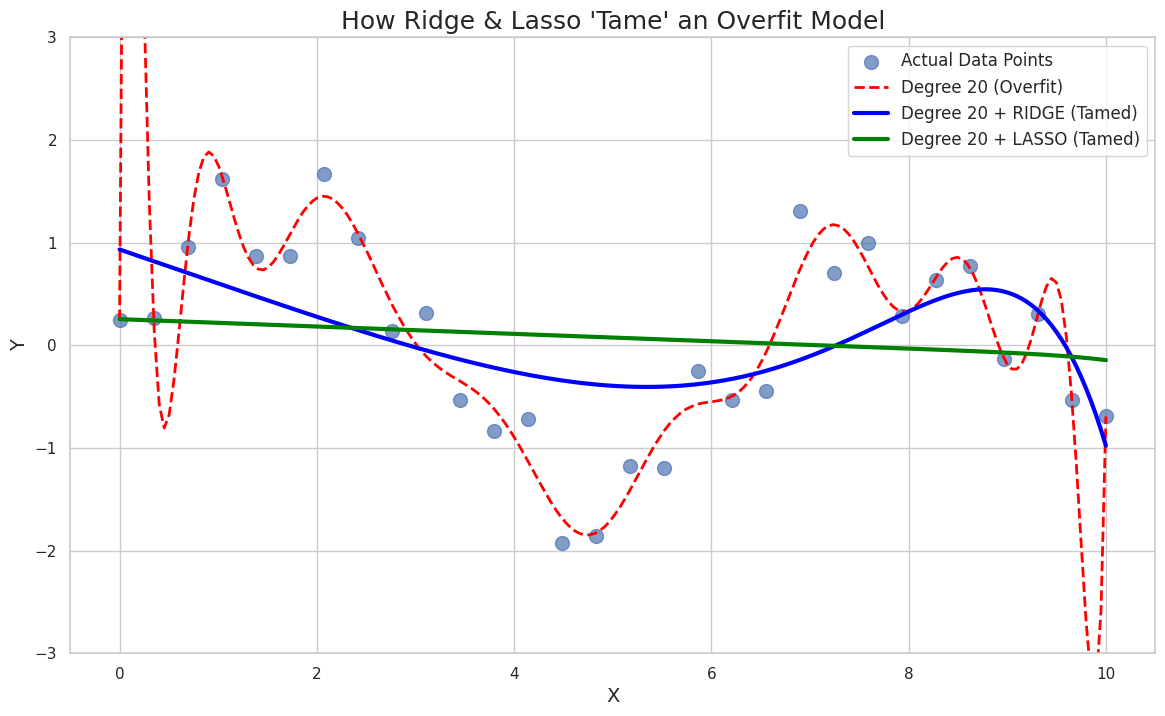


--- Look at the plot! ---
The RED line is the 'crazy' overfit model.
The BLUE (Ridge) and GREEN (Lasso) lines are 'tamed'!
They are still Degree 20, but the 'penalty' smoothed them out.

--- The 'Proof' is in the Coefficients ---
Max Coefficient (Overfit): 10250160956524.75
Max Coefficient (Ridge):   0.98
Max Coefficient (Lasso):   0.11

... and Lasso's special trick ...
Lasso set 19 out of 20 coefficients to ZERO!
It 'fired' the useless features!


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style
sns.set_theme(style="whitegrid")
np.random.seed(42) # for reproducible results
N_SAMPLES = 30 # Use fewer samples to make overfitting more obvious

print("--- Running Ridge & Lasso Demo ---")

# --- 1. Create our "true" curved data (same as before) ---
X_true = np.linspace(0, 10, N_SAMPLES)
y_true = np.sin(X_true) + np.random.normal(0, 0.5, N_SAMPLES)
X_true_reshaped = X_true.reshape(-1, 1)

# --- 2. Create models with and without regularization ---
# We will use Degree=20 for all models
DEGREE = 20

# Model 1: "Overfit" (Plain Linear Regression)
model_overfit = Pipeline([
    ('poly', PolynomialFeatures(degree=DEGREE)),
    ('scaler', StandardScaler()), # MUST scale data for regularization
    ('linear', LinearRegression())
])
model_overfit.fit(X_true_reshaped, y_true)

# Model 2: "Tamed with Ridge"
# We set alpha=1.0 as a good starting penalty
model_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=DEGREE)),
    ('scaler', StandardScaler()), # MUST scale data
    ('ridge', Ridge(alpha=1.0)) # This is the only difference!
])
model_ridge.fit(X_true_reshaped, y_true)

# Model 3: "Tamed with Lasso"
# alpha needs to be smaller for Lasso, e.g., 0.1
model_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=DEGREE)),
    ('scaler', StandardScaler()), # MUST scale data
    ('lasso', Lasso(alpha=0.1, max_iter=10000)) # This is the only difference!
])
model_lasso.fit(X_true_reshaped, y_true)

# --- 3. Plot the results ---
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)
y_plot_overfit = model_overfit.predict(X_plot)
y_plot_ridge = model_ridge.predict(X_plot)
y_plot_lasso = model_lasso.predict(X_plot)

plt.figure(figsize=(14, 8))
plt.scatter(X_true, y_true, s=100, alpha=0.7, label="Actual Data Points")
plt.plot(X_plot, y_plot_overfit, color='red', lw=2, linestyle='--', label="Degree 20 (Overfit)")
plt.plot(X_plot, y_plot_ridge, color='blue', lw=3, label="Degree 20 + RIDGE (Tamed)")
plt.plot(X_plot, y_plot_lasso, color='green', lw=3, label="Degree 20 + LASSO (Tamed)")

plt.title("How Ridge & Lasso 'Tame' an Overfit Model", fontsize=18)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.legend(fontsize=12)
plt.ylim(-3, 3) # Keep y-axis scale the same
plt.show()

print("\n--- Look at the plot! ---")
print("The RED line is the 'crazy' overfit model.")
print("The BLUE (Ridge) and GREEN (Lasso) lines are 'tamed'!")
print("They are still Degree 20, but the 'penalty' smoothed them out.")

# --- 4. Look at the "Why": The Coefficients ---

# Get coefficients from the 'linear' step of the pipeline
coefs_overfit = model_overfit.named_steps['linear'].coef_
# Get coefficients from the 'ridge' step
coefs_ridge = model_ridge.named_steps['ridge'].coef_
# Get coefficients from the 'lasso' step
coefs_lasso = model_lasso.named_steps['lasso'].coef_

print("\n--- The 'Proof' is in the Coefficients ---")
print(f"Max Coefficient (Overfit): {np.max(np.abs(coefs_overfit)):.2f}")
print(f"Max Coefficient (Ridge):   {np.max(np.abs(coefs_ridge)):.2f}")
print(f"Max Coefficient (Lasso):   {np.max(np.abs(coefs_lasso)):.2f}")

print("\n... and Lasso's special trick ...")
# Count how many coefficients Lasso set to EXACTLY zero
zeros_lasso = np.sum(coefs_lasso == 0)
print(f"Lasso set {zeros_lasso} out of {DEGREE} coefficients to ZERO!")
print("It 'fired' the useless features!")

In [23]:
model_lasso

Pipeline(steps=[('poly', PolynomialFeatures(degree=20)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=10000))])